In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import torch.utils.data as Data
import matplotlib.pyplot as plt
import random

In [60]:
ratings = pd.read_csv('~/Data/clean_rating4.csv')

idx_to_animes = list(set(ratings['anime_id'].tolist()))
idx_to_users = list(set(ratings['user_id'].tolist()))
anime_to_idx = {anime: idx for idx, anime in enumerate(idx_to_animes)}
user_to_idx = {user: idx for idx, user in enumerate(idx_to_users)}
num_users, num_animes = len(idx_to_users), len(idx_to_animes)

train_ratio = 0.9
# all_users = list(set(ratings.user_id))
# train_sample = random.sample(all_users, int(num_users * train_ratio))
# train_data = ratings[ratings.user_id.isin(train_sample)]
# test_data = list(set(all_users) - set(train_sample))
# print(train_data.shape)

data_ps = np.array(ratings.values.tolist())
train_data = data_ps[:int(train_ratio * len(data_ps))]
test_data = data_ps[int(train_ratio * len(data_ps)):]
print(train_data.shape, test_data.shape)

from collections import defaultdict
user_item_dic, data, labels = defaultdict(list), [], []
for d in train_data:
    user_item_dic[user_to_idx[d[0]]].append(anime_to_idx[d[1]])
    data.append([user_to_idx[d[0]], anime_to_idx[d[1]]])
    if d[2] != -1:
        labels.append(d[2] / 10)
    else:
        labels.append(fill_rating(anime_to_idx[d[1]]))

(2084856, 3) (231651, 3)


In [61]:
def get_hot_items():
    animes = pd.read_csv("~/Data/anime.csv")
    animes = animes[animes["anime_id"].isin(idx_to_animes)].loc[:, ["anime_id", "rating", "members"]].fillna(0)

    scalar = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))
    animes["rating_norm"] = animes[["rating"]].apply(scalar)
    animes["members_norm"] = animes[["members"]].apply(scalar)
    animes["weight"] = 0.6 * animes["rating_norm"] + 0.4 * animes["members_norm"]
    animes = animes.sort_values(by = "weight", ascending = False)
    
    return {anime_to_idx[i[0]]: i[1] for i in animes[["anime_id", "weight"]].values}

In [59]:
hot_items = get_hot_items()
keys, animes = hot_items.keys(), [i for i in range(num_animes)]
def fill_rating(anime_id):
    return hot_items[anime_id]

In [62]:
class NCFDataset(Data.Dataset):
    def __init__(self, data_ps, users, labels):
        super(NCFDataset, self).__init__()
        self.data = data_ps
        self.users = users
        self.label = labels

    def __getitem__(self, idx):
        user = self.data[idx][0]
        item = self.data[idx][1]
        label = self.label[idx]

        return user, item, label

    def __len__(self):
#         return self.num_ng * len(self.users) + len(self.data_ps)
        return len(self.data)

In [63]:
batch_size = 5120
users = [user_to_idx[i] for i in list(set(train_data[:, 0]))]
dataset = NCFDataset(data, users, labels)

data_iter = Data.DataLoader(dataset, batch_size = batch_size, shuffle = True)
for user, item, label in data_iter:
    print(label.shape)
    break

torch.Size([5120])


In [64]:
class NCF(nn.Module):
    def __init__(self, num_users, num_items, model, factor_num = 8, num_layers = 3,
               MLP_model = None, GMF_model = None, alpha = 0.5, dropout = 0.5):
        super(NCF, self).__init__()
        self.MLP_model = MLP_model
        self.GMF_model = GMF_model
        self.alpha = alpha
        self.dropout = dropout
        self.user_embed_GMF = nn.Embedding(num_users, factor_num)
        self.item_embed_GMF = nn.Embedding(num_items, factor_num)
        self.user_embed_MLP = nn.Embedding(num_users, factor_num * (2 ** (num_layers - 1)))
        self.item_embed_MLP = nn.Embedding(num_items, factor_num * (2 ** (num_layers - 1)))
        self.sigmoid = nn.Sigmoid()

        self.MLP = nn.Sequential(
            nn.Dropout(p = self.dropout),
            nn.Linear(factor_num * (2 ** num_layers), factor_num * (2 ** (num_layers - 1))),
            nn.ReLU()
        )
        for layer in range(num_layers - 1, 0, -1):
            self.MLP.add_module('dropout' + str(num_layers - layer), nn.Dropout(p = self.dropout))
            self.MLP.add_module('linear' + str(num_layers - layer), nn.Linear(factor_num * (2 ** layer), factor_num * (2 ** (layer - 1))))
            self.MLP.add_module('relu' + str(num_layers - layer), nn.ReLU())

        self.model = model
        if self.model in ['GMF', 'MLP']:
            self.NeuMF = nn.Linear(factor_num, 1)
        else:
            self.NeuMF = nn.Linear(2 * factor_num, 1)

        self.__init_weights__()

    def __init_weights__(self):
        if self.model in ['GMF', 'MLP']:
            nn.init.normal_(self.user_embed_GMF.weight, std = 0.01)
            nn.init.normal_(self.item_embed_GMF.weight, std = 0.01)
            nn.init.normal_(self.user_embed_MLP.weight, std = 0.01)
            nn.init.normal_(self.item_embed_MLP.weight, std = 0.01)

            for layer in self.MLP:
                if isinstance(layer, nn.Linear):
                    nn.init.xavier_uniform_(layer.weight)
#                   nn.init.normal_(layer.weight, std = 0.01)

            nn.init.kaiming_uniform_(self.NeuMF.weight, a = 1, nonlinearity = 'sigmoid')
#             nn.init.normal_(self.NeuMF.weight, std = 0.01)

        elif self.GMF_model and self.MLP_model:
            self.user_embed_GMF.weight.data.copy_(self.GMF_model.user_embed_GMF.weight)
            self.item_embed_GMF.weight.data.copy_(self.GMF_model.item_embed_GMF.weight)
            self.user_embed_MLP.weight.data.copy_(self.MLP_model.user_embed_MLP.weight)
            self.item_embed_MLP.weight.data.copy_(self.MLP_model.item_embed_MLP.weight)

            for (m1, m2) in zip(self.MLP, self.MLP_model.MLP):
                if isinstance(m1, nn.Linear) and isinstance(m2, nn.Linear):
                    m1.weight.data.copy_(m2.weight)
                    m1.bias.data.copy_(m2.bias)

            NeuMF_weight = torch.cat((self.alpha * self.GMF_model.NeuMF.weight, (1 - self.alpha) * self.MLP_model.NeuMF.weight), 1)
            NeuMF_bias = self.GMF_model.NeuMF.bias + self.MLP_model.NeuMF.bias

            self.NeuMF.weight.data.copy_(NeuMF_weight)
            self.NeuMF.bias.data.copy_(NeuMF_bias)
            
    def forward(self, user, item):
        if self.model is 'GMF' or 'NCF':
            user_embed_GMF = self.user_embed_GMF(user)
            item_embed_GMF = self.item_embed_GMF(item)
            
#             print(user_embed_GMF.device, item_embed_GMF.decive)
            GMF_output = user_embed_GMF * item_embed_GMF

        if self.model is 'MLP' or 'NCF':
            user_embed_MLP = self.user_embed_MLP(user)
            item_embed_MLP = self.item_embed_MLP(item)

            MLP_input = torch.cat((user_embed_MLP, item_embed_MLP), 1)
            MLP_output = self.MLP(MLP_input)

        if self.model is 'NCF':
            output = self.NeuMF(torch.cat((MLP_output, GMF_output), 1))
        elif self.model is 'MLP':
            output = self.NeuMF(MLP_output)
        elif self.model is 'GMF':
            output = self.NeuMF(GMF_output)
            
        return self.sigmoid(output)

In [65]:
MLP_Loss, GMF_Loss, NCF_Loss = [], [], [] 
def train(net, num_epochs, lr, train_type = 'NCF'):
    print(train_type)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     device = torch.device('cpu')
    print('train on', device)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr = lr)
    loss = nn.MSELoss()
    for epoch in range(num_epochs):
        l_sum,n = 0, 0
        for user, item, label in data_iter:
            user = user.to(device)
            item = item.to(device)
            label = label.to(device)
            pred = net(user, item)
            l = loss(pred.view(label.shape), label.float())

            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            l_sum += l.cpu().item()
            n += 1
            
        if train_type == "MLP":
            MLP_Loss.append(l_sum / n)
        elif train_type == "GMF":
            GMF_Loss.append(l_sum / n)
        elif train_type == "NCF":
            NCF_Loss.append(l_sum / n)
            
        print(epoch + 1, l_sum / n)

In [66]:
MLP_net = NCF(num_users, num_animes, model = 'MLP')
train(MLP_net, 30, lr = 0.0001, train_type = 'MLP')

GMF_net = NCF(num_users, num_animes, model = 'GMF')
train(GMF_net, 30, lr = 0.0001, train_type = 'GMF')

NCF_net = NCF(num_users, num_animes, model = 'NCF', GMF_model = GMF_net, MLP_model = MLP_net)
train(NCF_net, 30, lr = 0.0001)

MLP
train on cuda
1 0.05055103606233994
2 0.02836231305720467
3 0.02248989138752222
4 0.020677382021448483
5 0.019755479729022172
6 0.019067840961118538
7 0.01847629439469208
8 0.017994927666971788
9 0.01759950087551831
10 0.017265572399814046
11 0.016973909940205367
12 0.01670047058039071
13 0.016470116318897436
14 0.016263453958683883
15 0.016137182342765087
16 0.01601739135552563
17 0.015909732278326854
18 0.015824775172707934
19 0.015755656442385826
20 0.015704126861950784
21 0.01564739402566178
22 0.015606125125058871
23 0.015567534836009145
24 0.015527065126590576
25 0.01549083958882108
26 0.015464930477844295
27 0.015435034107855138
28 0.01541552100074934
29 0.015387434592269654
30 0.015381464867067396
GMF
train on cuda
1 0.11659630199930832
2 0.10969336708898053
3 0.09892526877057903
4 0.0848500161048244
5 0.06941940853664395
6 0.0547210076531651
7 0.04244820628424778
8 0.033362494786178656
9 0.02727307778253567
10 0.02344828391192006
11 0.021111187593573156
12 0.01965930702292

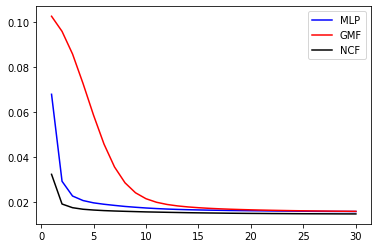

In [19]:
x_data = [n for n in range(1, 31)]
mlp, = plt.plot(x_data, MLP_Loss, color = 'blue')
gmf, = plt.plot(x_data, GMF_Loss, color = 'red')
ncf, = plt.plot(x_data, NCF_Loss, color = 'black')
plt.legend([mlp, gmf, ncf], ['MLP', 'GMF', 'NCF'])
plt.savefig("loss.jpg")
plt.show()

In [79]:
def metrics(net, test_data, bound):
    users = list(set(test_data[:,0].tolist()))
    recall, precise = [], []
    for user in users:
        all_items = torch.LongTensor([i for i in range(num_animes)]).cuda()
        test_user = torch.LongTensor([user for i in range(num_animes)]).cuda()
        pred = net(test_user, all_items)
#         print(pred.shape)
        _, idx = torch.topk(pred, k = 5, dim = 0)
        
        target = [anime_to_idx[i[1]] for i in ratings[ratings.user_id == user].values if i[2] > bound]
        if not target: continue
        idx = idx.cpu().numpy().flatten()
        overlap = list(set(target) & set(idx))
        recall.append(len(overlap) / len(target))
        precise.append(len(overlap) / len(idx))
        
#         print(recall[-1], precise[-1])
        
    return np.mean(precise)

In [12]:
torch.save(NCF_net.state_dict(), "NCF1.pt")
torch.save(GMF_net.state_dict(), "GMF1.pt")
torch.save(MLP_net.state_dict(), "MLP1.pt")

In [80]:
# model = NCF(num_users, num_animes, model = 'NCF', GMF_model = GMF_net, MLP_model = MLP_net).cuda()
# model.load_state_dict(torch.load("NCF.pt"))
precise = []
for bound in range(10):
    precise.append(metrics(NCF_net, test_data, bound))
    
print(precise)

[0.14497816593886464, 0.1388646288209607, 0.14716157205240177, 0.1388646288209607, 0.14148471615720526, 0.1502183406113537, 0.13799126637554585, 0.1318777292576419, 0.10218340611353711, 0.06578366445916115]


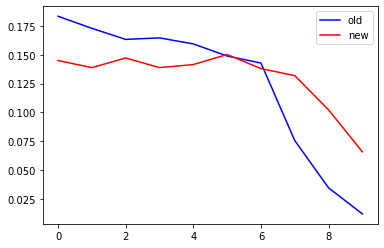

In [81]:
tmp = [0.18340611353711792, 0.17292576419213973, 0.16331877729257643, 0.1646288209606987, 0.15938864628820962, 0.14890829694323146, 0.1427947598253275, 0.07554585152838426, 0.03449781659388646, 0.011920529801324504]
x_data = [n for n in range(10)]
test, = plt.plot(x_data, tmp, color = 'blue')
fact, = plt.plot(x_data, precise, color = 'red')

plt.legend([test, fact], ['old', 'new'])
plt.savefig("precision.jpg")
plt.show()